# 경구 약제 이미지 분류
### 단일 경구약제 1000종 데이터
> 전체 데이터가 3.65TB이기 떄문에 노트북이나 드라이브 용량 사정상 전체 데이터가 불가능 했다.  
> 그래서 데이터 다운로드시 각 이미지를 분리해서 다운 받을 수 있게 되어있어 용량을 확인해보았다. 단일 경구약제 1000종 데이터중 훈련데이터에서 가장 작은 용량이 13GB였는데 이중에서 라벨링 데이터(json)에 있는 이미지 파일만 가져와서 사용을 하였다(1300장 가량)  
> 이 데이터 내에서 train, val, test를 나누어서 사용해보고자 한다.


# 1. 이미지 로딩 및 유틸 import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/sw_single_project/json/K-038929_json

/content/drive/MyDrive/sw_single_project/json/K-038929_json


In [13]:
cd /content/drive/MyDrive/sw_single_project/pill_imgs/res

/content/drive/MyDrive/sw_single_project/pill_imgs/res


In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import json
from glob import glob
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 데이터 확인
df = pd.DataFrame()
for i, name in enumerate(glob('*.json')):
  with open(name) as f:
    data = json.load(f)
    json_test = pd.json_normalize(data["images"])
    df = df.append(json_test,ignore_index=True)
df

In [5]:
# 필요 없는 데이터 처치 
"""  
# 필요한 데이터 # 표시
{
			"file_name": "K-039036_0_1_1_2_90_160_200.png",  
			"width": 976, 
			"height": 1280,
			"imgfile": "K-039036_0_1_1_2_90_160_200.png", #
			"drug_N": "K-039036", #
			"drug_S": "정상알약", #
			"back_color": "파랑색 배경", #
			"drug_dir": "뒷면", #
			"light_color": "주백색", 
			"camera_la": 90,
			"camera_lo": 160,
			"size": 200, 
			"dl_idx": "39035",
			"dl_mapping_code": "K-039036",#
			"dl_name": "리프레가캡슐 75mg",#
			"dl_name_en": "Lyfrega Cap. 75mg",#
			"img_key": "http://connectdi.com/design/img/drug/147541209851800144.jpg",
			"dl_material": "프레가발린",#
			"dl_material_en": "Pregabalin",#
			"dl_custom_shape": "경질캡슐제",#
			"dl_company": "(주)셀트리온제약",#
			"dl_company_en": "Celltrion Pharm",#
			"di_company_mf": "",
			"di_company_mf_en": "",
			"item_seq": 201602889,
			"di_item_permit_date": "20160524",
			"di_class_no": "[01190]기타의 중추신경용약",#
			"di_etc_otc_code": "전문의약품",#
			"di_edi_code": "693902240",
			"chart": "흰색 또는 연한 노란색을 띄는 흰색의 분말이 든 상부 적갈색, 하부 흰색의 경질캡슐제 ",
			"drug_shape": "장방형",
			"thick": 5.32,#
			"leng_long": 14.2,#
			"leng_short": 5.05,#
			"print_front": "CLP 643",
			"print_back": "",
			"color_class1": "갈색",
			"color_class2": "하양",
			"line_front": "",
			"line_back": "",
			"img_regist_ts": "20160928",
			"form_code_name": "경질캡슐제, 산제",
			"mark_code_front_anal": "",
			"mark_code_back_anal": "",
			"mark_code_front_img": "",
			"mark_code_back_img": "",
			"mark_code_front": "",
			"mark_code_back": "",
			"change_date": "20210609",
			"id": 1
		}
"""
df = df[["file_name","drug_N","drug_S","back_color","drug_dir","dl_mapping_code","dl_name","dl_name_en","dl_material","dl_material_en","dl_custom_shape","di_etc_otc_code"]]

In [ ]:
# 결측치 없음
df.isnull().sum()

In [7]:
# 데이터 라벨 가져오기
img = df['file_name']
pill = df['dl_name']
target_pill = sorted(list(set(pill)))
print(target_pill)
print(len(target_pill))

['뉴에르도테캡슐', '듀카브정30/10밀리그램', '듀카브정30/5밀리그램', '라노펜세미정', '락토엔큐캡슐(바실루스리케니포르미스균)\xa0', '루키오정10밀리그램(몬테루카스트나트륨)', '리셀톤캡슐 6.0mg', '리프레가캡슐 75mg', '뮤코원캡슐(에르도스테인)', '바실리포미스캡슐', '베아로탄정 50mg', '베아투스정', '비오메틱스캡슐(바실루스리케니포르미스균)', '비우미정 500mg/병', '아나그레캡슐 0.5mg', '앤도민300프리미엄연질캡슐 300mg/PTP', '에피나레정', '엘도민캡슐 300mg', '엘도스인캡슐(에르도스테인)', '크라틴정 10mg', '크라틴정 20mg', '크라틴정 5mg', '티아프란정', '피타로틴정 2mg']
24


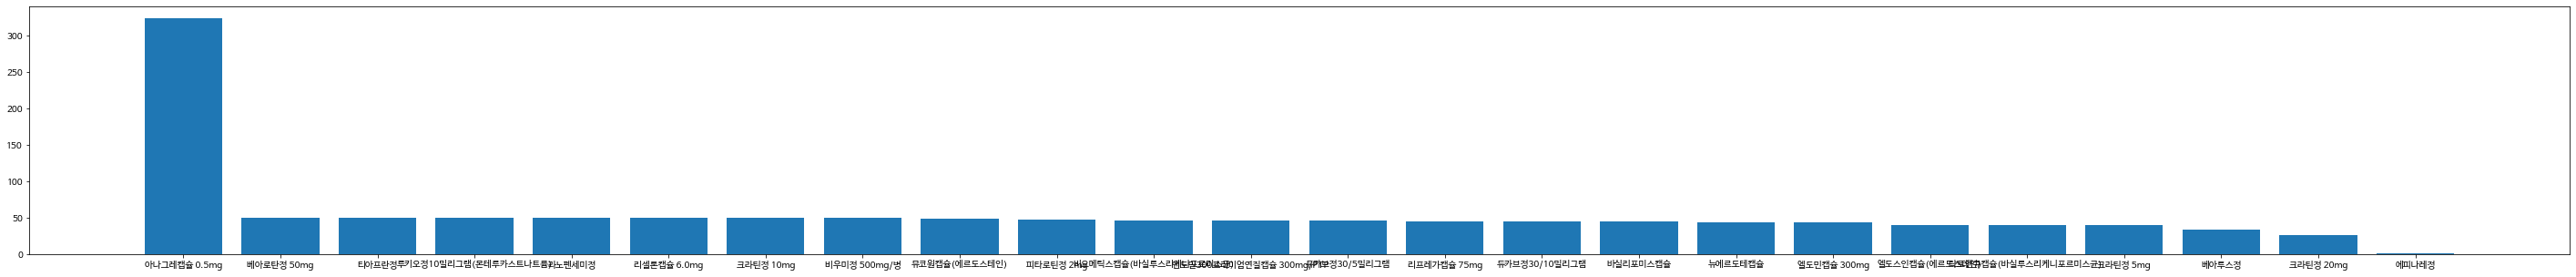

In [9]:
cnt = pill.value_counts()
plt.rc('font', family="NanumBarunGothic")
plt.figure(figsize=(50, 5))
plt.bar(cnt.index, cnt.values)
plt.show()

In [ ]:
idx = df[df.dl_name == '아나그레캡슐 0.5mg'].index
df.drop(idx[:200], inplace=True)
df

In [ ]:
cnt = pill.value_counts()
cnt

In [14]:
X_pics = [Image.open(img_name).convert("RGB") for img_name in df["file_name"]]

In [15]:
#이미지를 배열로 변환
X = [ cv2.resize(np.array(i),(64, 64)) for i in X_pics]

In [16]:
# minmax 스케일링(정규화)
X = [i/255.0 for i in X]
X = np.array(X)

In [ ]:
# 원 핫 인코딩
ohe = OneHotEncoder(sparse=False)
df_ohe = pd.DataFrame(df[['dl_name']])
y = ohe.fit(df_ohe)
y = ohe.transform(df[['dl_name']])
y

In [18]:
#Keras CNN
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import optimizers
from sklearn.model_selection import train_test_split

In [19]:
# 원본데이터로 train, test를 분류하고  train데이터로 train, validation을 분류함

# train - 학습데이터(검증데이터 포함)  test- 테스트데이터
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

# train - 최종 학습데이터, val - 검증데이터
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
# resnet
def train():

    model = Sequential()

    # convolution
    model.add(Convolution2D(128,3,3, input_shape=(64,64,3)))
    model.add(Activation("relu"))

    model.add(Convolution2D(128,3,3,padding="SAME"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))
    
    # convolution
    model.add(Convolution2D(64,3,3, activation="relu"))
    model.add(Activation("relu"))
    model.add(Convolution2D(64,3,3,padding="SAME" ))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding="SAME"))

    model.add(Flatten())

    # NN
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation="softmax"))
    
    model.compile(optimizer="Adam", loss="categorical_crossentropy",metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
model = train()
history1 = model.fit(X_train,y_train,verbose=True,validation_data=(X_val, y_val),epochs=50)
# history1 = model.fit_generator(train_gen.flow(train_gen_set,y_train, batch_size = 30)
#     ,verbose=True,validation_data=(X_val, y_val),epochs=50)


7/7 [==============================] - 0s 19ms/step - loss: 0.3463 - accuracy: 0.8423


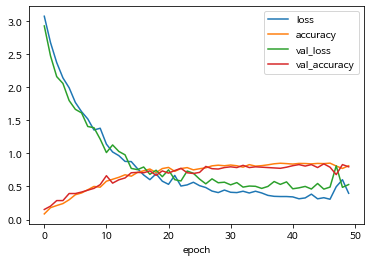

In [22]:
locc,acc = model.evaluate(X_test,y_test)

plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')

plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
predict = model.predict(X_test)

7/7 [==============================] - 0s 17ms/step


In [ ]:
predict_list = []
for i in predict:
  idx = max(i)
  predict_list.append(list(i).index(idx))
per = 0
for index, i in enumerate(predict_list):
  print(f'X_test {index+1} 번째 이미지의 예측은 {target_pill[i]}입니다. 예측확률은 {max(predict[index])*100:.2f}%입니다.')
  per += max(predict[index])*100
print(f'평균 예측 확률은 {per/len(predict)}%입니다.')

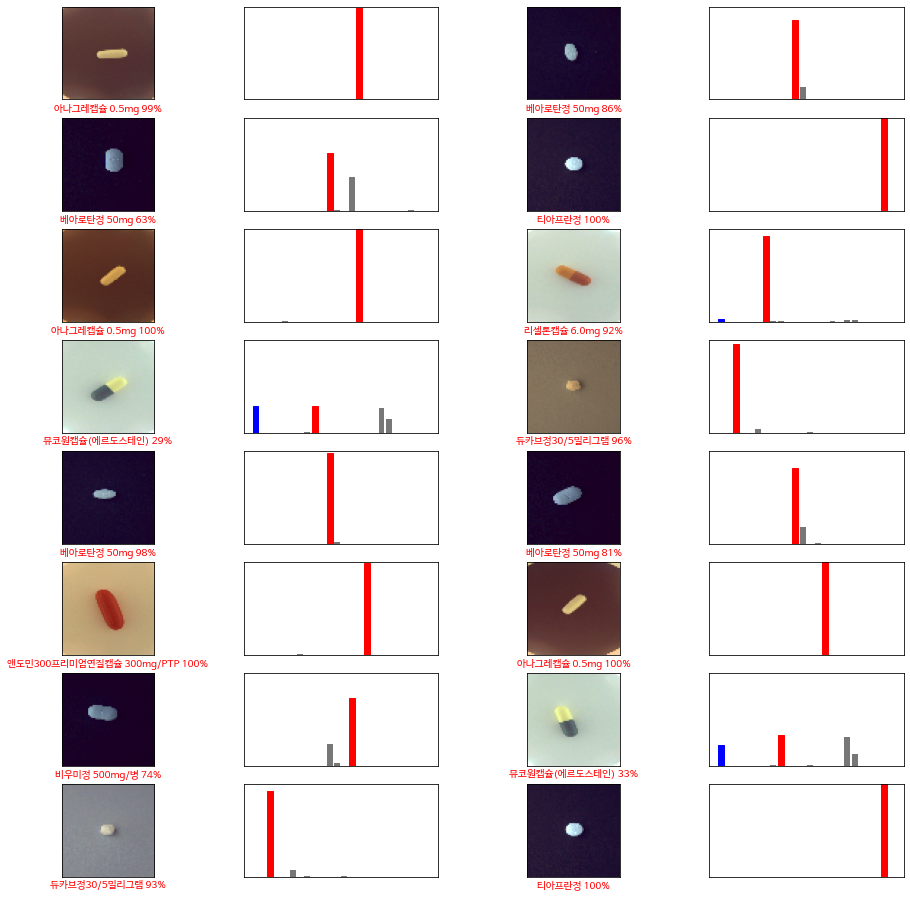

In [28]:
def plot_image(i, predict_list, label, img):
  predict_list, label, img = predict_list[i], label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predict_label = np.argmax(predict_list)
  if predict_label == np.argmax(label):
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f'{target_pill[predict_label]} {100 * np.max(predict_list):2.0f}%',color=color)

def plot_value_array(i, predict_list, label):
  predict_list, label = predict_list[i], label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  now = plt.bar(range(24), predict_list, color = "#777777")
  plt.ylim([0,1])
  predict_label = np.argmax(predict_list)
  now[predict_label].set_color('red')
  now[np.argmax(label)].set_color('blue')


row = 8
col = 2
images = row * col
plt.figure(figsize=(8*col, 2*row))

for i in range(images):
  plt.subplot(row, 2*col, 2*i+1)
  plot_image(i,predict, target_pill ,X_test)
  plt.subplot(row, 2*col, 2*i+2)
  plot_value_array(i, predict, target_pill)
